# Introduction - Classification of histopathology images

### About:

This project is about developing Deep Learning Model (DNN) for histopathology images classification. <br>
Histopathology refers to the microscopic examination of tissue in order to study the manifestations of disease. (Source - Wikipedia) <br>
By developing such DNN model, we can automate and improve the diagnostic process. <br>

### Notebook Content:

The following notebook consist of 3 main parts:
* Part 1 - Training different DNN models and evaluating their performences for the classification task.
* Part 2 - Plotting Confusion matrix, PCA and TNSE visualization (For best performing model from part 1).
* Part 3 - Coloring Large histopathology images (5000 x 5000 x 3 RGB ), for tumor and other cells representation.

### The dataset:

Colorectal histology dataset: <br>
Classification of textures in colorectal cancer histology. <br>
5,000 Examples. Each example is a 150 x 150 x 3 RGB image of one of 8 classes:
* Tumor
* Stroma
* Complex
* Lympho
* Debris
* Mucosa
* Adipose
* Empty

# Imports
All the libraries used in this project are imported in the following section.

In [ ]:
# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# SKLearn
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# TensorFlow
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load the Colorectal_Histology Dataset

* Load the dataset from tensorflow dataset API. <br>
* Split into Train - Test groups.

Train: 4000 	 Test: 1000

Example Dataset Images:
{0: 'Tumor', 1: 'Stroma', 2: 'Complex', 3: 'Lympho', 4: 'Debris', 5: 'Mucosa', 6: 'Adipose', 7: 'Empty'}


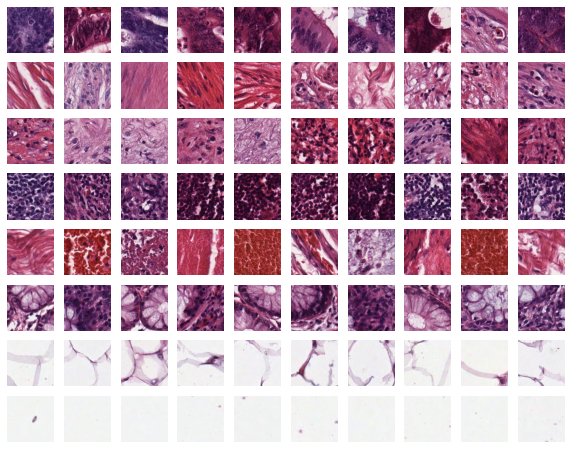

In [ ]:
# Fetch data from tensorflow dataset
(train_ds, test_ds) = tfds.load(
    'colorectal_histology',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True)

# Create lists
X_train,y_train,X_test,y_test = [],[],[],[]

# Convert tensorflow dataframe to list of numpy arrays
for entry in tfds.as_numpy(train_ds):
    X_train.append(entry[0])
    y_train.append(entry[1])
    
for entry in tfds.as_numpy(test_ds):
    X_test.append(entry[0])
    y_test.append(entry[1])
    
# List to numpy array
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# Print how many classified images loaded
print("Train:",len(X_train),"\t Test:",len(X_test))

# Label dictionary
Label_dic = {0:'Tumor', 1:'Stroma', 2:'Complex', 3:'Lympho', 4:'Debris', 5:'Mucosa', 6:'Adipose', 7:'Empty'}

# Print example images
print('\nExample Dataset Images:')
print(Label_dic)

plt.figure(figsize = (10,8))
for label_i in range(8): # For each label
    for example_j in range(10): # Print 5 examples
        plt.subplot(8,10,(example_j + label_i*10)+1)
        plt.axis('off')
        plt.imshow(X_train[y_train==label_i][example_j])
plt.show()

# Part 1 - Training and Evaluation of different models

## Model #1 - Convolutional Neural Network

This model uses Conv2D & MaxPooling2D layers, and Adam optimizer.

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 128)       73856   

<function matplotlib.pyplot.grid>

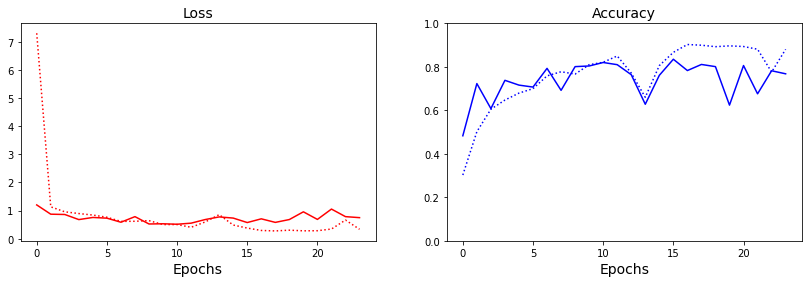

In [ ]:
# --- Define Model ---
m1 = Sequential(name='CNN')
m1.add(Input(shape=(150,150,3)))

m1.add(Conv2D(32, (3,3), activation='relu', padding='same'))
m1.add(Conv2D(32, (3,3), activation='relu', padding='same'))
m1.add(MaxPooling2D((2,2)))

m1.add(Conv2D(64, (3,3), activation='relu', padding='same'))
m1.add(Conv2D(64, (3,3), activation='relu', padding='same'))
m1.add(MaxPooling2D((2,2)))

m1.add(Conv2D(128, (3,3), activation='relu', padding='same'))
m1.add(Conv2D(128, (3,3), activation='relu', padding='same'))
m1.add(MaxPooling2D((2,2)))

m1.add(Flatten())
m1.add(Dense(256, activation='relu'))
m1.add(Dropout(0.5))
m1.add(Dense(8, activation='softmax'))

m1.compile(optimizer='adam',
           loss='sparse_categorical_crossentropy',
           metrics=['accuracy'])

m1.summary()

# --- Fit Model ---
h1 = m1.fit(X_train, y_train, epochs=24, batch_size=128,
            validation_data=(X_test, y_test), verbose=0)

# --- Print Accuracy Score ---
print('\nTrain accuracy = ',round(h1.history['accuracy'][-1],3))
print('Test accuracy = ',round(h1.history['val_accuracy'][-1],3))

# --- Plot Accuracy & Loss graphs ---
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(h1.history['loss'],':r')
plt.plot(h1.history['val_loss'],'r')
plt.title('Loss', fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid

plt.subplot(1,2,2)
plt.plot(h1.history['accuracy'],':b')
plt.plot(h1.history['val_accuracy'],'b')
plt.ylim([0,1])
plt.title('Accuracy', fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid

## Model #2 - VGG16 Transfer Learning

This model uses pre-trained VGG16 network with 'imagenet' weights (Top is removed).
Optimizers - Adam (Top training) & SGD (Fine tuning)

Model: "VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 4104      
Total params: 18,913,608
Trainable params: 4,198,920
Non-trainable params: 14,714,688
_________________________________________________________________

Train accuracy =  0.992
Test accuracy =  0.879


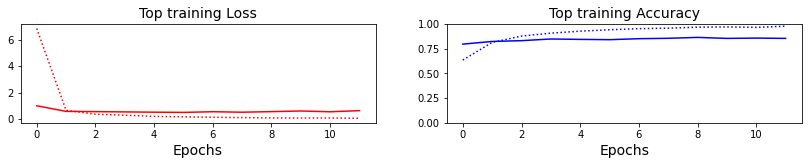

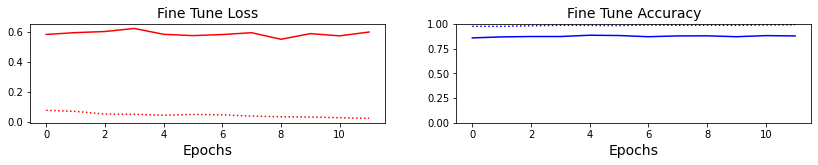

In [ ]:
# --- Define Model ---
m2 = Sequential(name='VGG16')

# --- Load VGG16 & imagenet weights ---
vgg16 = tf.keras.applications.VGG16(input_shape=(150,150,3), include_top=False,weights='imagenet')
vgg16.trainable = False

# --- Head Layers ---
m2.add(vgg16)
m2.add(Flatten())
m2.add(Dense(512, activation='relu'))
m2.add(Dropout(0.5))
m2.add(Dense(8, activation='softmax'))

m2.compile(optimizer='adam',
           loss='sparse_categorical_crossentropy',
           metrics=['accuracy'])

m2.summary()

# --- Fit Model (Top only training) ---
h2a = m2.fit(X_train, y_train, epochs=12, batch_size=128,
            validation_data=(X_test, y_test), verbose=0)

# --- Unlock weights & Fine-Tune ---
opt = keras.optimizers.SGD(
learning_rate=0.0001, momentum=0.9, nesterov=True)

# Allow training
m2.trainable = True

# Recompile
m2.compile(optimizer=opt,
           loss='sparse_categorical_crossentropy',
           metrics=['accuracy'])

# fit
h2b = m2.fit(X_train, y_train, epochs=12, batch_size=128,
            validation_data=(X_test, y_test), verbose=0)

# --- Print Accuracy Score ----
print('\nTrain accuracy = ',round(h2b.history['accuracy'][-1],3))
print('Test accuracy = ',round(h2b.history['val_accuracy'][-1],3))

# --- Plot Accuracy & Loss graphs ---
plt.figure(figsize=(14,4))
plt.subplot(2,2,1)
plt.plot(h2a.history['loss'],':r')
plt.plot(h2a.history['val_loss'],'r')
plt.title('Top training Loss', fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid

plt.subplot(2,2,2)
plt.plot(h2a.history['accuracy'],':b')
plt.plot(h2a.history['val_accuracy'],'b')
plt.ylim([0,1])
plt.title('Top training Accuracy', fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid

plt.figure(figsize=(14,4))
plt.subplot(2,2,3)
plt.plot(h2b.history['loss'],':r')
plt.plot(h2b.history['val_loss'],'r')
plt.title('Fine Tune Loss', fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid

plt.subplot(2,2,4)
plt.plot(h2b.history['accuracy'],':b')
plt.plot(h2b.history['val_accuracy'],'b')
plt.ylim([0,1])
plt.title('Fine Tune Accuracy', fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid

plt.show()

## Model #3 - VGG16 Transfer Learning + Data Augmentation

This model uses pre-trained VGG16 network with 'imagenet' weights (Top is removed). <br>
In addition, Data augmentation is being used to increase training examples. <br>
This time the data is passed through VGG16 Preprocess function. <br>
Optimizers - Adam (Top training) & SGD (Fine tuning)

Model: "VGG16_DA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 4104      
Total params: 18,913,608
Trainable params: 4,198,920
Non-trainable params: 14,714,688
_________________________________________________________________

Train accuracy =  0.93
Test accuracy =  0.929


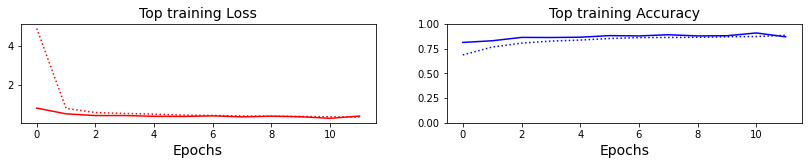

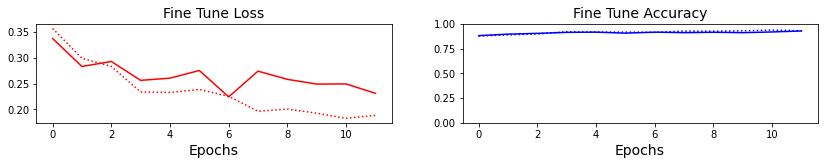

In [ ]:
# --- Define Model ---
m3 = Sequential(name='VGG16_DA')

# --- Load VGG16 & imagenet weights ---
vgg16 = tf.keras.applications.VGG16(input_shape=(150,150,3), include_top=False,weights='imagenet')
vgg16.trainable = False

# --- Head Layers ---
m3.add(vgg16)
m3.add(Flatten())
m3.add(Dense(512, activation='relu'))
m3.add(Dropout(0.5))
m3.add(Dense(8, activation='softmax'))

m3.compile(optimizer='adam',
           loss='sparse_categorical_crossentropy',
           metrics=['accuracy'])

m3.summary()

# --- Data Augmentation Generator ---
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=1,
    height_shift_range=1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

# Train & test data generators
data_iter_train = datagen.flow(X_train, y_train, batch_size= 128)
data_iter_test = datagen.flow(X_test, y_test, batch_size= 128)

# --- Fit Model (Top only training) ---
h3a = m3.fit(data_iter_train,validation_data=data_iter_test, epochs=12, batch_size=128, verbose=0)

# --- Unlock weights & Fine-Tune ---
opt = keras.optimizers.SGD(
learning_rate=0.0001, momentum=0.9, nesterov=True)

# Allow training
m3.trainable = True

# Recompile
m3.compile(optimizer=opt,
           loss='sparse_categorical_crossentropy',
           metrics=['accuracy'])

# fit
h3b = m3.fit(data_iter_train,validation_data=data_iter_test, epochs=12, batch_size=128, verbose=0)

# --- Print Accuracy Score ----
print('\nTrain accuracy = ',round(h3b.history['accuracy'][-1],3))
print('Test accuracy = ',round(h3b.history['val_accuracy'][-1],3))

# --- Plot Accuracy & Loss graphs ---
plt.figure(figsize=(14,4))
plt.subplot(2,2,1)
plt.plot(h3a.history['loss'],':r')
plt.plot(h3a.history['val_loss'],'r')
plt.title('Top training Loss', fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid

plt.subplot(2,2,2)
plt.plot(h3a.history['accuracy'],':b')
plt.plot(h3a.history['val_accuracy'],'b')
plt.ylim([0,1])
plt.title('Top training Accuracy', fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid

plt.figure(figsize=(14,4))
plt.subplot(2,2,3)
plt.plot(h3b.history['loss'],':r')
plt.plot(h3b.history['val_loss'],'r')
plt.title('Fine Tune Loss', fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid

plt.subplot(2,2,4)
plt.plot(h3b.history['accuracy'],':b')
plt.plot(h3b.history['val_accuracy'],'b')
plt.ylim([0,1])
plt.title('Fine Tune Accuracy', fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid

plt.show()

## Models Comparison

Plot training accuracy graphs and compare all models performences.

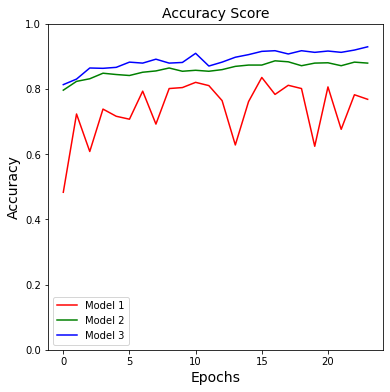

In [ ]:
# -- Compare models training accuracy
plt.figure(figsize=(6,6))
plt.subplot(1,1,1)
h1 = h1.history['val_accuracy']
h2 = h2a.history['val_accuracy'] + h2b.history['val_accuracy']
h3 = h3a.history['val_accuracy'] + h3b.history['val_accuracy']
plt.plot(h1,'r')
plt.plot(h2,'g')
plt.plot(h3,'b')
plt.legend(['Model 1','Model 2','Model 3'])
plt.ylim([0,1])
plt.title('Accuracy Score', fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.grid
plt.show()

# Part 2 - Confusion Matrix, PCA & TNSE Visualization

Choose the best model from Part 1, and plot visualizations which help us to analyze its classifications.

In [ ]:
# --- Chosen Best Model ---
model = m3

# --- Check if data needs to be pre processed ---
if model == m3:
    pre_process_bool = True
else:
    pre_process_bool = False

# --- Print Model Layers ---
print('Model Layers:\n')
for i,l in enumerate(model.layers):
    print(i,' ',l.name,'\n   ',l.output_shape[1:],'\n')
    
# --- Choose layer index for visualization ---
layer_n = 2

Model Layers:

0   vgg16 
    (4, 4, 512) 

1   flatten_2 
    (8192,) 

2   dense_4 
    (512,) 

3   dropout_2 
    (512,) 

4   dense_5 
    (8,) 



## Confusion Matrix
Print confusion Matrix to analyze model error.

In [ ]:
# --- Calculate model predictions for test dataset ---
if pre_process_bool == True:
    y_predict = model.predict(preprocess_input(X_test)).argmax(axis = 1)
else:
    y_predict = model.predict(X_test).argmax(axis = 1)

# --- Calculate Confusion Matrix ---
confusion_mat =  confusion_matrix(y_test, y_predict)

# --- Display confusion matrix as dataframe with label names ---
confusion_mat_df = pd.DataFrame(confusion_mat, index=Label_dic.values(), columns=Label_dic.values())

# --- Print correct / incorrect classifications ---
total_correct = np.sum(np.diag(confusion_mat_df)) # Correct predictions
total_amount = len(y_test) # Total amount of examples
tumor_correct = confusion_mat_df.loc['Tumor','Tumor'] # Correct tumor predictions
tumor_amount = np.sum(confusion_mat_df.loc['Tumor']) # Total amount of tumor examples

print('Correct classifications: ',total_correct,'out of', total_amount ,'examples',
      '-',round(total_correct*100/total_amount,2),'%')
print('Correct Tumor classifications: ',tumor_correct,'out of', tumor_amount ,'examples',
     '-',round(tumor_correct*100/tumor_amount,2),'%')

confusion_mat_df

Correct classifications:  934 out of 1000 examples - 93.4 %
Correct Tumor classifications:  107 out of 112 examples - 95.54 %


,Tumor,Stroma,Complex,Lympho,Debris,Mucosa,Adipose,Empty
Tumor,107,1,2,0,0,2,0,0
Stroma,0,117,4,1,5,0,0,0
Complex,5,11,114,0,6,1,0,0
Lympho,0,0,11,115,0,0,0,0
Debris,0,10,1,0,115,0,0,0
Mucosa,0,0,1,2,0,125,0,0
Adipose,0,0,0,0,0,0,116,2
Empty,0,0,0,0,0,0,1,125


## PCA and TNSE Visualization

Use dimension reduction technics in order to visualize the relationship between the classification labeling and the selected layer output.


Layer:  dense_4 , Shape:  (None, 512)


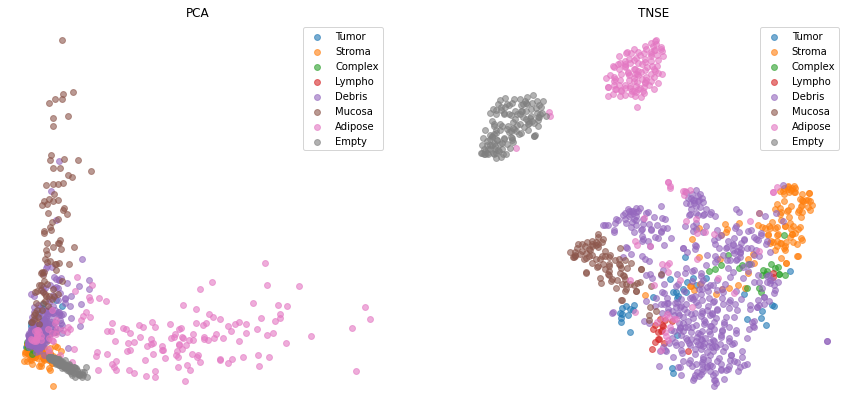

In [ ]:
# Layer for feature PCA display
print('\nLayer: ',model.layers[layer_n].name,', Shape: ', model.layers[layer_n].output_shape)

# Model for feature presentation
activations = keras.Model(inputs=model.inputs, outputs=model.layers[layer_n].output)

# Calculate last layer
activations_map = activations.predict(X_test)

# Define PCA
pca = PCA(n_components=2).fit(activations_map)
features_2D_PCA = pca.transform(activations_map)

# Define TNSE
features_2D_TNSE = TSNE(n_components=2).fit_transform(activations_map)

# Plot PCA scatter
plt.figure(figsize = (15,7))
plt.subplot(121)

for label_i in np.unique(y_predict):
    plt.scatter(features_2D_PCA[y_predict==label_i][:,0], features_2D_PCA[y_predict==label_i][:,1],
                s=35, alpha=0.6, label=Label_dic[label_i])
plt.title('PCA')
plt.axis('off')
plt.xlabel('PC-1',fontsize=14)
plt.ylabel('PC-2',fontsize=14)
plt.legend()

# Plot TNSE scatter
plt.subplot(122)
for label_i in np.unique(y_predict):
    plt.scatter(features_2D_TNSE[y_predict==label_i][:,0], features_2D_TNSE[y_predict==label_i][:,1],
                s=35, alpha=0.6, label=Label_dic[label_i])
plt.title('TNSE')
plt.axis('off')
plt.xlabel('Axis 1',fontsize=14)
plt.ylabel('Axis 2',fontsize=14)
plt.legend()

plt.show()

# Part 3 - Coloring Large histopathology images

Use trained model in order to color Large histopathology images (5000 x 5000 x 3 RGB) for tumor and other cells representation.

## Load Large histopathology Dataset
* Load the dataset from tensorflow dataset API.
* Dataset contains 10 Large histopathology images - (5000 X 5000 X 3 RGB)

Images Detected: 10

Image shape:  (5000, 5000, 3)




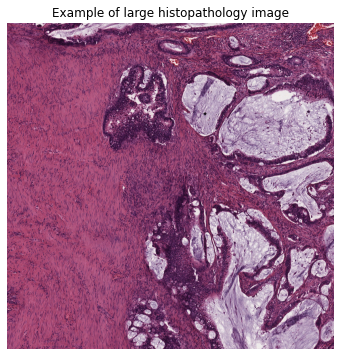

In [ ]:
# Load large colorectal_histology dataset
large_tfds = tfds.load('colorectal_histology_large', split=['test'])

# Create lists
large_ds = []

# Convert tensorflow dataframe to list of numpy arrays
for entry in tfds.as_numpy(large_tfds[0]):
    large_ds.append(entry)

# List to numpy array
large_ds = np.asarray(large_ds)

# Print how many imgs exist in the dataset
large_imgs_amount = len(large_ds)
print("Images Detected:",large_imgs_amount)

# Print image shape
print("\nImage shape: ",large_ds[0]['image'].shape)

# Print example image
print('\n')
plt.figure(figsize=(6,6))
plt.title('Example of large histopathology image')
plt.axis('off')
plt.imshow(large_ds[0]['image'])

## Extract Patches for labeling
Split large image into smaller patches. <br>
Run the patches through the model and predict classification.

In [ ]:
# Img size (5000)
img_size = len(large_ds[0]['image'])

# Amount of patches per axis - Use Overlap to increase output resolution.
overlap = 2 # value 2 equivalent to 50% overlap
sample_size = (img_size*overlap//150)-1

# Array to store results
result_a = np.ndarray((large_imgs_amount,sample_size,sample_size)) # Prediction Labeling Color
result_b = np.ndarray((large_imgs_amount,sample_size,sample_size)) # Tumor Heatmap

# Iterate Imgs
for large_index in range(large_imgs_amount):
    img = large_ds[large_index]['image']
    
    # Extract Patches
    for i in range(sample_size):
        for j in range(sample_size):
            i_patch = int((i*150)/overlap)
            j_patch = int((j*150)/overlap)
            patch = img[i_patch:i_patch+150,j_patch:j_patch+150] # Extract patch
            if pre_process_bool == True:
                patch = preprocess_input(patch)

            # Classify patch
            patch = np.expand_dims(patch, axis=0)
            prediction = model.predict(patch)
            result_a[large_index,i,j] = int(prediction.argmax()) # Predicted Label
            result_b[large_index,i,j] = prediction[0][0] # Tumor Probability = Label 0
    print("Analyzed image #",large_index+1)

Analyzed image # 1
Analyzed image # 2
Analyzed image # 3
Analyzed image # 4
Analyzed image # 5
Analyzed image # 6
Analyzed image # 7
Analyzed image # 8
Analyzed image # 9
Analyzed image # 10


## Output - Colored Large histopathology images and Tumor probability heatmap

Display original image, label prediction color map, and Tumor probability heatmap

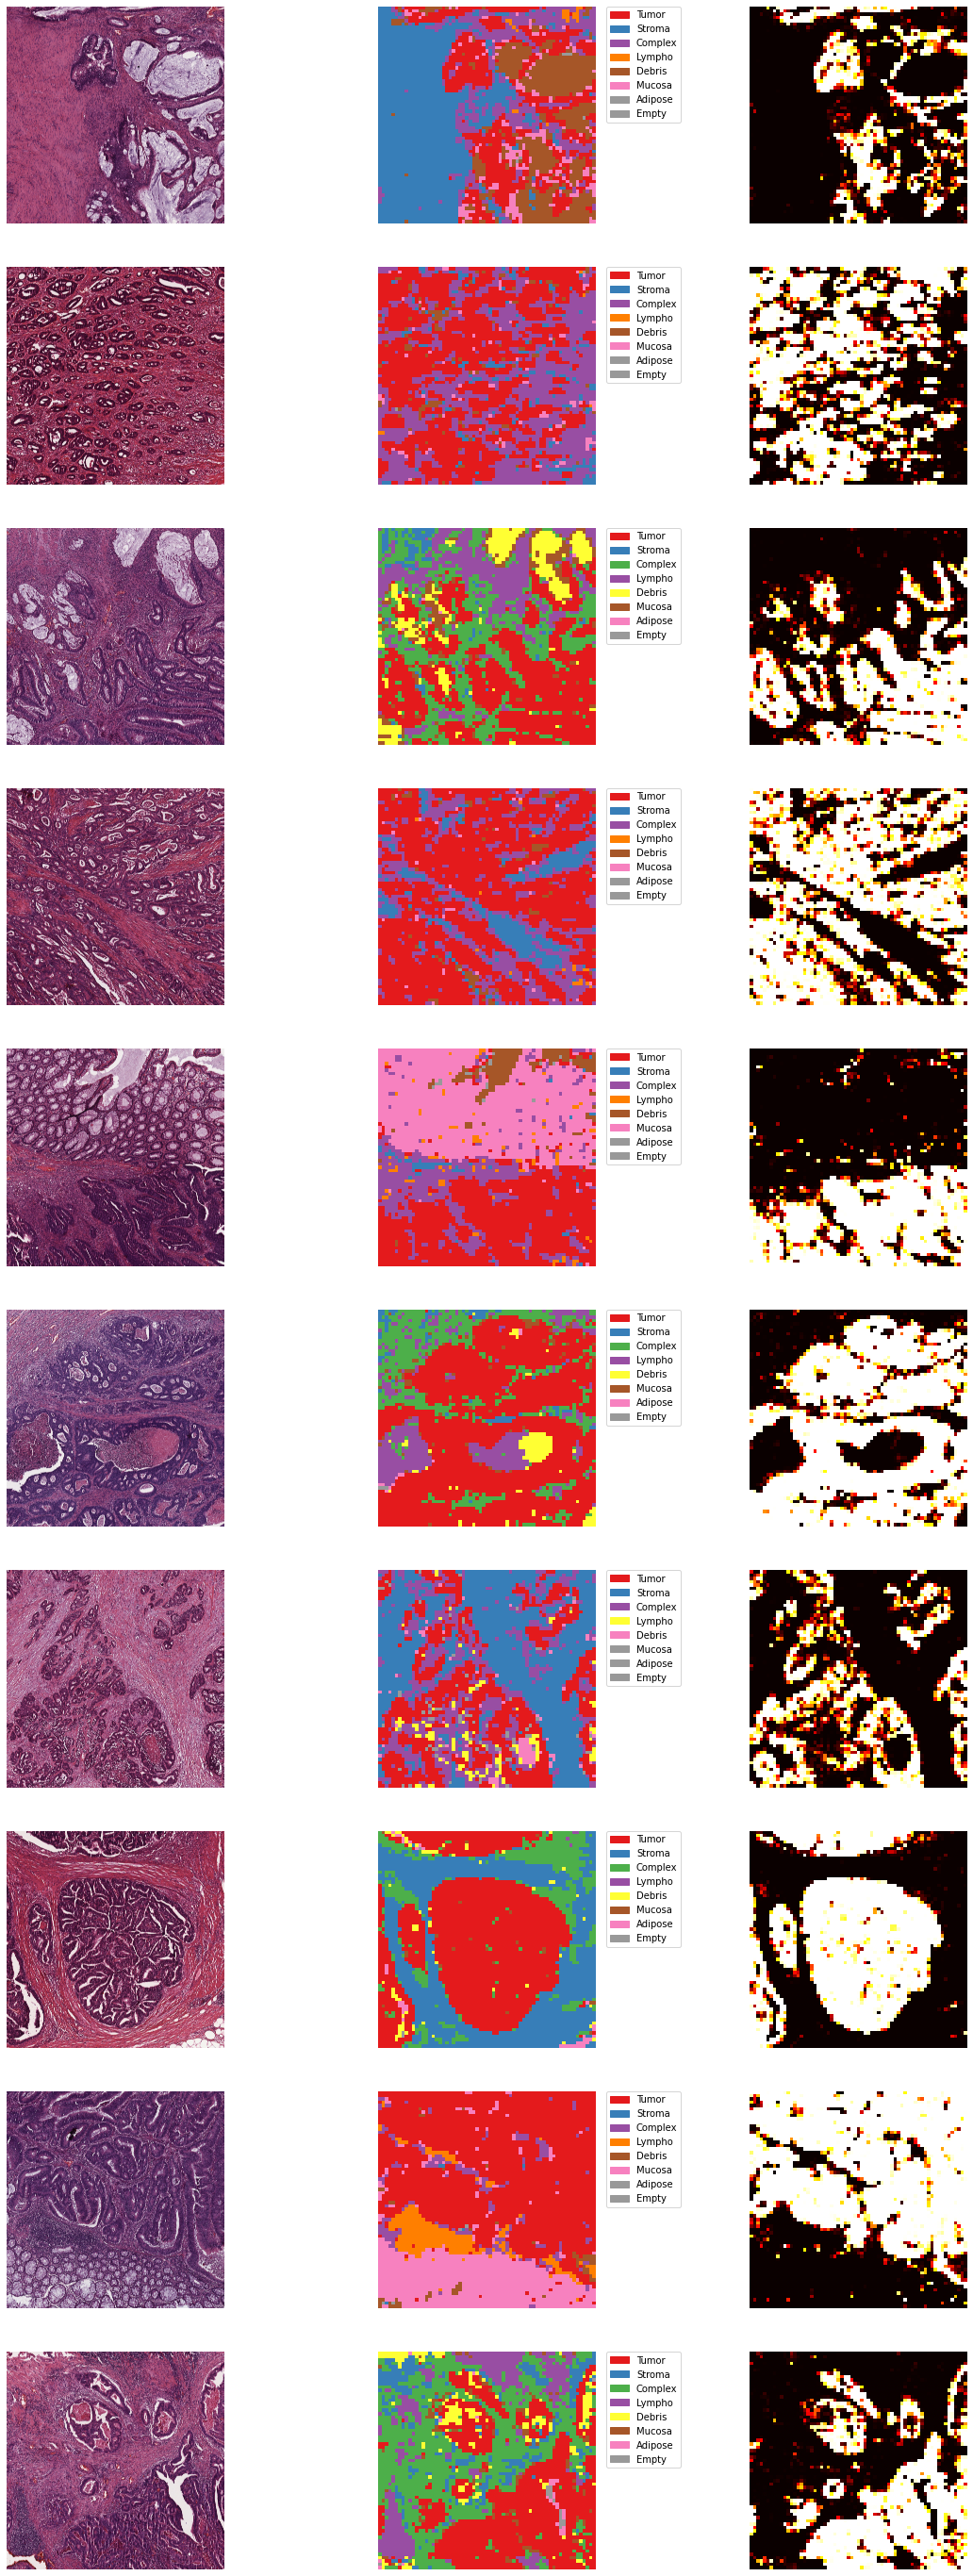

In [ ]:
# Figure size
plt.figure(figsize = (20,large_imgs_amount*5))

# Iterate images
for image_index in range(large_imgs_amount):
    # Original Image
    plt.subplot(large_imgs_amount,3,image_index*3 + 1)
    plt.axis('off')
    plt.imshow(large_ds[image_index]['image'])

    # Predicted Label Coloring
    plt.subplot(large_imgs_amount,3,image_index*3 + 2)
    plt.axis('off')
    im = plt.imshow(result_a[image_index], cmap='Set1')
    values = np.unique(y_test) # Get label values
    colors = [ im.cmap(im.norm(value)) for value in values] # Get colors used for plotting
    patches = [ mpatches.Patch(color=colors[i], label=Label_dic[i] ) for i in range(len(values)) ] # Legend values
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

    # Tumor heatmap
    plt.subplot(large_imgs_amount,3,image_index*3 + 3)
    plt.axis('off')
    plt.imshow(result_b[image_index], cmap='hot')

plt.show()